# Simulated data

## 1: Implement subroutine generating random data

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Code received from Lukas
def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df

## 2: Generate testset of 10000 analytes under two conditions measured in 3 replicates.

In [3]:
diff_expr_df, diff_label_df = generate_expression_data(n_analytes=10000, n_samples=2, n_replicates=3, p_regulated=0.2)
null_expr_df, null_label_df = generate_expression_data(n_analytes=10000, n_samples=2, n_replicates=3, p_regulated=0)


## 3: Calculate p-values

Example t-test.

In [4]:
test_res = stats.ttest_ind([1,2,3], [2,3,4])
test_res.pvalue

0.28786413472669081

In [5]:
s1_labels = ["s1_1", "s1_2", "s1_3"]
s2_labels = ["s2_1", "s2_2", "s2_3"]
features = diff_label_df.index

In [6]:
# sub_df = expr_df.iloc[0:5]
# # print(sub_df)
# s1_cols = sub_df[s1_labels]
# print(s1_cols)
# s2_cols = sub_df[s2_labels]
# print(s2_cols)
# print(stats.ttest_ind(s1_cols, s2_cols).pvalue)
# print(stats.ttest_ind(s1_cols, s2_cols, axis=1).pvalue)

In [7]:
diff_test_results = stats.ttest_ind(diff_expr_df.loc[features,s1_labels], diff_expr_df.loc[features,s2_labels], axis=1)
diff_p_vals = diff_test_results.pvalue

In [8]:
diff_p_vals[0:10]

array([ 0.68997118,  0.43292291,  0.76669927,  0.80465947,  0.30103934,
        0.11607661,  0.4127422 ,  0.71146774,  0.62873913,  0.90092578])

In [9]:
null_test_results = stats.ttest_ind(null_expr_df.loc[features,s1_labels], null_expr_df.loc[features,s2_labels], axis=1)
null_p_vals = null_test_results.pvalue

## 4: Implement subroutine for calculating q-value

* Let p_1 <= p_2 <= p_m be ordered p-values
* For a range lambda, say lambda = 0, 0.01, 0.02.., 0.95 calculate: pi0(lambda) = # {p_j > lambda} / m(1-lambda)
* Let f be the natural cubic spline (in our case - average for high p-values)
* Set estimate of pi_0 to be: pi_0 = f(1)
* Calculate q(p(m)) = min((pi_0*m*t)/#{p_i <= t}) = pi_0 * p(m)
* For i = m - 1, m - 2, ..., 1 calculate:
* The estimated q is the ith most significant feaure is q(p(i))

In [10]:
def estimate_pis(pvals):
    
    pi_0_vals = list()
    
    for sub_thres in np.arange(0.01, 0.96, 0.01):
        sub_p = [p for p in pvals if p > sub_thres]
        sub_p_count = len(sub_p)
        m = len(pvals)
        pi_0 = sub_p_count / (m * (1-sub_thres))
        pi_0_vals.append(pi_0)
  
    return pi_0_vals

def estimate_pi_zero(pis, thres):
    
    tot = len(pis)
    start_ind = int(tot * thres)
    sub = pis[start_ind:]
    return np.mean(sub)


### Diff test

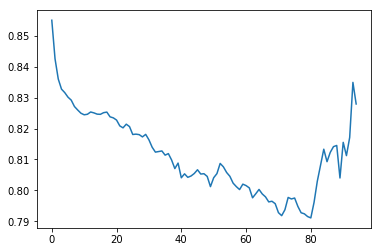

In [11]:
diff_pi_0_vals = estimate_pis(diff_p_vals)
plt.plot(diff_pi_0_vals)
plt.show()

### Null test

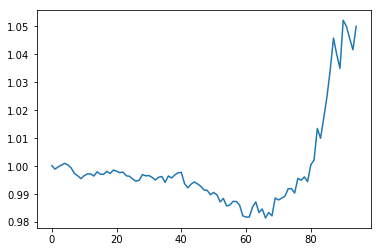

In [12]:
null_pi_0_vals = estimate_pis(null_p_vals)
plt.plot(null_pi_0_vals)
plt.show()

#### q-value calculations

In [13]:
def estimate_q_vals(pvals):
    pi_estimates = estimate_pis(pvals)
    pi_0 = estimate_pi_zero(pi_estimates, 0.75)
    m = len(pvals)
    
    fdr_vals = list()
    for t in sorted(pvals):
#     for i in range(len(pvals)):
        val = pi_0 * m * t / (len(fdr_vals) + 1)
        fdr_vals.append(val)
#         q_vals.append(min(fdr_vals))

    q_vals = list()
    for sub_i in range(1, len(fdr_vals)):
        fdr_slice = fdr_vals[len(fdr_vals) - sub_i:]
        q = min(fdr_slice)
        q_vals.insert(0, q)

    print("pi_0: {}".format(pi_0))
    print("m: {}".format(len(pvals)))
    return q_vals
    



In [14]:
diff_q_vals = estimate_q_vals(diff_p_vals)
null_q_vals = estimate_q_vals(null_p_vals)


pi_0: 0.805087073020147
m: 10000
pi_0: 1.016549010716066
m: 10000


In [15]:
print(diff_q_vals[0:10])
print(null_q_vals[0:10])

[0.00036633015233375824, 0.00036633015233375824, 0.00036633015233375824, 0.00036633015233375824, 0.00036633015233375824, 0.00036633015233375824, 0.00037136379584316387, 0.00037136379584316387, 0.00037136379584316387, 0.00037136379584316387]
[0.6226510727315735, 0.6226510727315735, 0.70661218903696488, 0.70661218903696488, 0.74513803464774209, 0.74513803464774209, 0.77131850487112008, 0.77131850487112008, 0.77131850487112008, 0.77131850487112008]


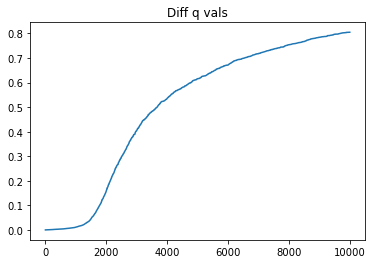

In [16]:
plt.plot(diff_q_vals)
plt.title("Diff q vals")
plt.show()

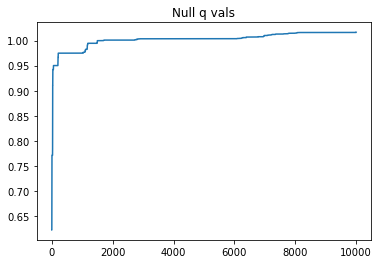

In [17]:
plt.plot(null_q_vals)
plt.title("Null q vals")
plt.show()

## 5: Differential expression genes, on q-threshold

In [53]:
xvals = np.arange(0, 0.5, 0.005)

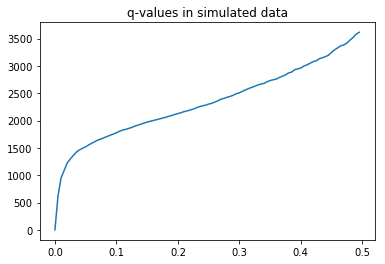

In [69]:
diff_counts = list()
for thres in xvals:
    diff_count = len([q for q in diff_q_vals if q <= thres])
    diff_counts.append(diff_count)
plt.plot(xvals, diff_counts)
plt.title('q-values in simulated data')
plt.show()

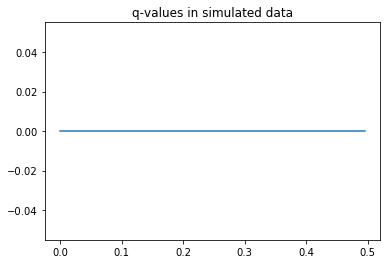

In [68]:
null_counts = list()
for thres in xvals:
    null_count = len([q for q in null_q_vals if q <= thres])
    null_counts.append(null_count)
plt.plot(xvals, null_counts)
plt.title('q-values in simulated data')
plt.show()

# 6: Plot difference between q-values and actual fraction of null statistics

In [25]:
diff_q_vals[0:10]

[0.00036633015233375824,
 0.00036633015233375824,
 0.00036633015233375824,
 0.00036633015233375824,
 0.00036633015233375824,
 0.00036633015233375824,
 0.00037136379584316387,
 0.00037136379584316387,
 0.00037136379584316387,
 0.00037136379584316387]

In [27]:
diff_p_vals[0:10]

array([ 0.68997118,  0.43292291,  0.76669927,  0.80465947,  0.30103934,
        0.11607661,  0.4127422 ,  0.71146774,  0.62873913,  0.90092578])

In [80]:
def get_true_diff_counts(pvals, labels, xvals):
    
    true_rows = labels.iloc[:,1] == 1
    true_pvals = pvals[true_rows]
    
    below_thres_counts = list()
    for thres in xvals:
        below_thres_count = [p for p in true_pvals if p <= thres]
        below_thres_counts.append(len(below_thres_count))
    
    return below_thres_counts

In [83]:
true_diff_counts = get_true_diff_counts(diff_p_vals, diff_label_df, xvals)

In [84]:
q_estimated_h1_count = list()
for i in range(len(true_diff_counts)):
    diff_count = diff_counts[i]
    x_frac = xvals[i]
    est_actual_diff_count = diff_count - diff_count * x_frac
    q_estimated_h1_count.append(est_actual_diff_count)

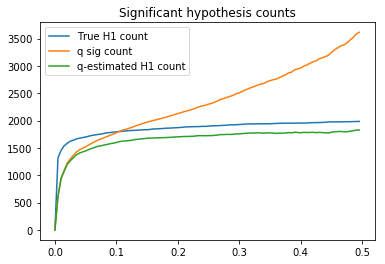

In [88]:
true_counts = plt.plot(xvals, true_diff_counts, label="True H1 count")
q_counts = plt.plot(xvals, diff_counts, label="q sig count")
q_est_true = plt.plot(xvals, q_estimated_h1_count, label="q-estimated H1 count")
plt.legend()
plt.title("Significant hypothesis counts")
plt.show()